* [Train.csv] : https://www.kaggle.com/prachi13/customer-analytics


* matplotlib 한글 깨짐 현상 해결
> 셀 실행 후 런타임 재시작 필요

In [14]:
import platform
print(platform.python_version())

3.8.8


In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# 00. 필요한 파이썬 라이브러리 불러오기
# Plotly
# 셀에서 다음 분석 결과에서 matplotlib 그래프가 그려짐
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.model_selection import train_test_split

# 모델 패키지 불러오기
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.cluster import KMeans

#평가에 필요한 패키지
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from sklearn.decomposition import PCA

import scipy.cluster.hierarchy as shc

from scipy.stats import pearsonr, chi2_contingency
from itertools import combinations
# Import and suppress warnings
import warnings


In [16]:
# Settings Warning and Plot Hangul
py.init_notebook_mode(connected=True)
warnings.filterwarnings('ignore')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'AppleGothic'

print("pandas version: ", pd.__version__)
pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 12)

pandas version:  2.0.2


* matplotlib 한글 깨짐 현상 해결
> 셀 실행 후 런타임 재시작 필요

#Part5. [실습4] 고객 데이터를 활용한 상품 배송 분석

## 01. 데이터 소개 및 분석프로세스 수립
 : "강의자료 → Ch06. [실습4] 고객 데이터를 활용한 상품 배송 분석" 참고

## 02. 데이터 준비를 위한 EDA 및 전처리

### 0. 데이터 불러오기

In [17]:
train = pd.read_csv('/Users/brianna/Downloads/Train.csv')
train.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [18]:
# 데이터의 모양 알아보기train.shape #행,열 개수
train.shape

(10999, 12)

### 1. 데이터 탐색

#### 1) 데이터 타입

In [19]:
# 컬럼별 데이터 타입 알아보기
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


#### 2) 데이터 통계값

In [20]:
# 컬럼별 간단한 통계값 보기
train.describe()
# 평균과 max/min값이 있는지 확인

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.00000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,5500.00000,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,3175.28214,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,1.00000,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,2750.50000,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,5500.00000,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,8249.50000,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,10999.00000,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


#### 3) 변수 간 관계 그래프

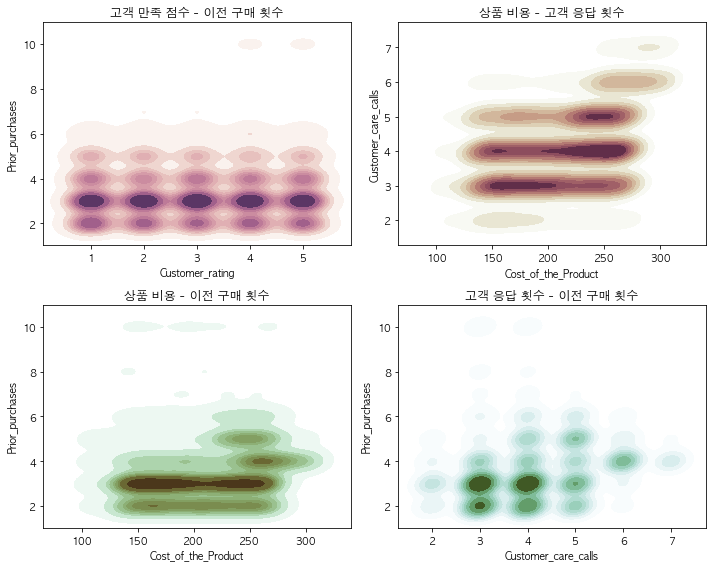

In [21]:
# 3) 변수 간 관계 그래프
# 여러 개의 KDE Plot 생성 준비
f, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=False, sharey=False)

# Plot 색상 설정
s = np.linspace(0, 3, 10)

# 1-1
cmap = sns.cubehelix_palette(start=0.0, light=1, as_cmap=True)
x = train['Customer_rating']
y = train['Prior_purchases']
sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, ax=axes[0, 0])
axes[0, 0].set(title='고객 만족 점수 - 이전 구매 횟수')

# 1-2
cmap = sns.cubehelix_palette(start=0.333333333333, light=1, as_cmap=True)
x = train['Cost_of_the_Product']
y = train['Customer_care_calls']
sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, ax=axes[0, 1])
axes[0, 1].set(title='상품 비용 - 고객 응답 횟수')

# 2-1
cmap = sns.cubehelix_palette(start=1.0, light=1, as_cmap=True)
x = train['Cost_of_the_Product']
y = train['Prior_purchases']
sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, ax=axes[1, 0])
axes[1, 0].set(title='상품 비용 - 이전 구매 횟수')

# 2-2
cmap = sns.cubehelix_palette(start=1.333333333333, light=1, as_cmap=True)
x = train['Customer_care_calls']
y = train['Prior_purchases']
sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, ax=axes[1, 1])
axes[1, 1].set(title='고객 응답 횟수 - 이전 구매 횟수')

f.tight_layout()
plt.show()

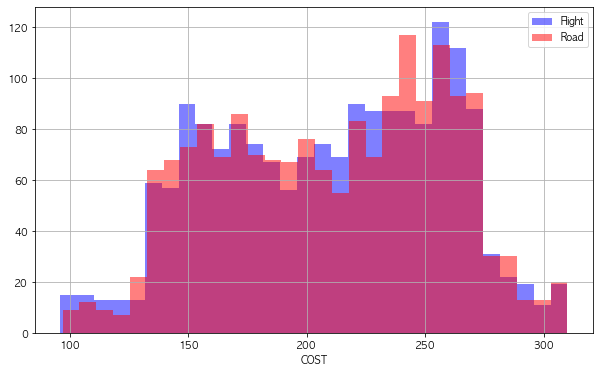

In [22]:
plt.figure(figsize=(10,6))
train[train['Mode_of_Shipment']=='Flight']['Cost_of_the_Product'].hist(alpha=0.5,color='blue',bins=30,label='Flight')
train[train['Mode_of_Shipment']=='Road']['Cost_of_the_Product'].hist(alpha=0.5,color='red',bins=30,label='Road')
plt.xlabel('COST')
plt.legend()
# 구매금액이 비쌀수록 flight로 배송되는 제품이 많을 것이다 > 아님!! 아래 그래프를 보면 알수있음

#### 4) 결측값

In [23]:
###### 코드 작성 부분 시작 ######
train.isnull().any()
###### 코드 작성 부분 마침 ######

ID                     False
Warehouse_block        False
Mode_of_Shipment       False
Customer_care_calls    False
Customer_rating        False
Cost_of_the_Product    False
Prior_purchases        False
Product_importance     False
Gender                 False
Discount_offered       False
Weight_in_gms          False
Reached.on.Time_Y.N    False
dtype: bool

#### 5) 중복값

In [24]:
# 중복된 항목 수 알아보기
print("중복된 항목 수 :", len(train[train.duplicated()])) 

중복된 항목 수 : 0


### 2. 데이터 전처리

#### 1) 데이터 컬럼명 수정

In [25]:
# .이 들어가는 순간 에러 확률 높아짐 > _로 바꿔줌 rename.()사용
train = train.rename(columns={'Reached.on.Time_Y.N': 'Reached_on_Time_Y_N'})

### 2. Target Feature 정의

#### 1) 데이터 탐색

In [26]:
# train.groupby('Reached_on_Time_Y_N').mean()
# train.groupby('Reached_on_Time_Y_N').median()

In [27]:
# target feature 비율 확인 > 크게 차이 없음
y = train['Reached_on_Time_Y_N'].copy()
y.value_counts()

Reached_on_Time_Y_N
1    6563
0    4436
Name: count, dtype: int64

#### 2) 숫자형 변수들과의 관계

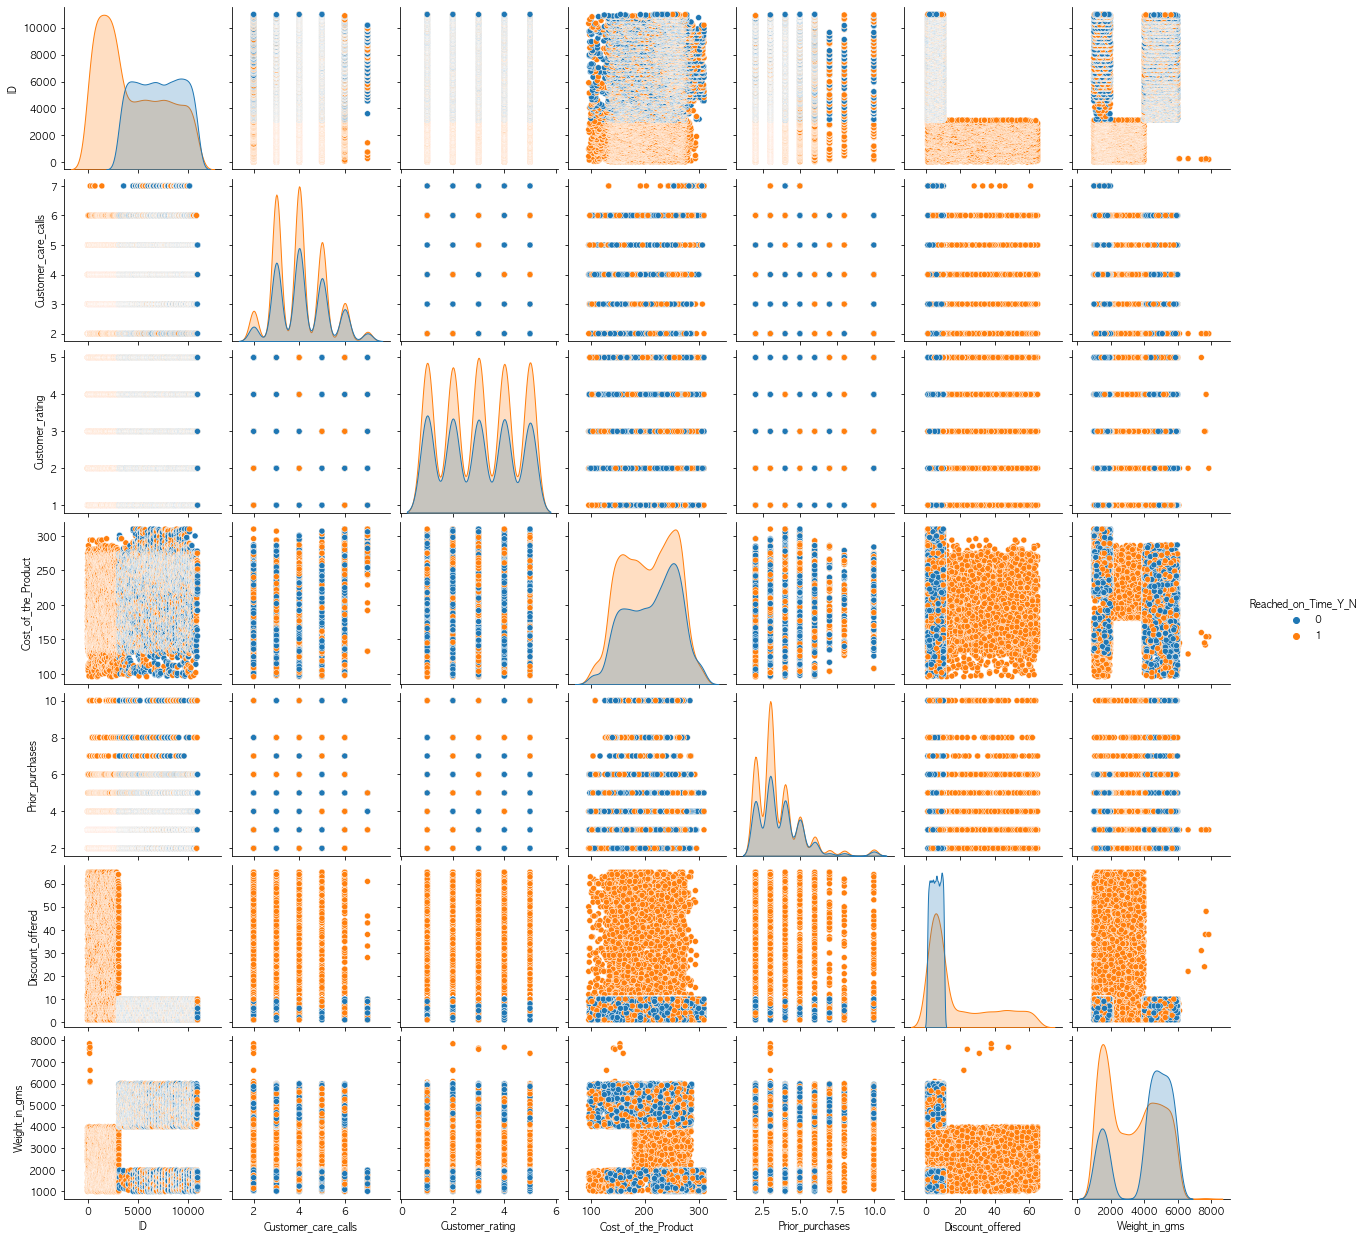

In [28]:
hue = 'Reached_on_Time_Y_N' # 기준
sns.pairplot(train.select_dtypes(include=np.number), hue=hue)
# target 변수 기준으로 각각 숫자형 변숙 선택하여서 그래프로 그림
plt.show()

#### 3) 각 변수별 Target Feature 그래프

> 이전 구매횟수 별 Target Feature

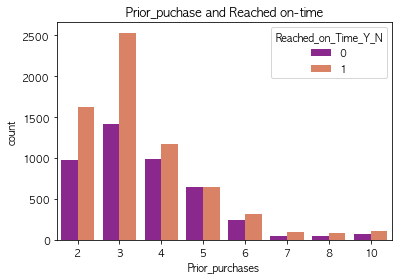

In [29]:
import seaborn as sb
from matplotlib import pyplot as plt
sb.countplot(x = "Prior_purchases", data = train, palette = "plasma",hue="Reached_on_Time_Y_N");
plt.title('Prior_puchase and Reached on-time')
plt.show()

> 고객 평가 점수별 Target Feature

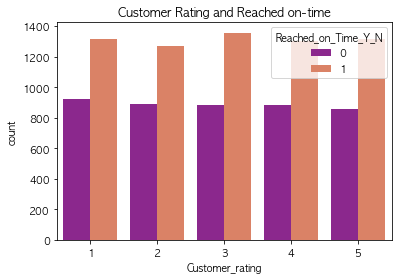

In [30]:
import seaborn as sb
from matplotlib import pyplot as plt
sb.countplot(x = "Customer_rating", data = train, palette = "plasma",hue="Reached_on_Time_Y_N");
plt.title('Customer Rating and Reached on-time')
plt.show()

> 상품 중요도별 Target Feature

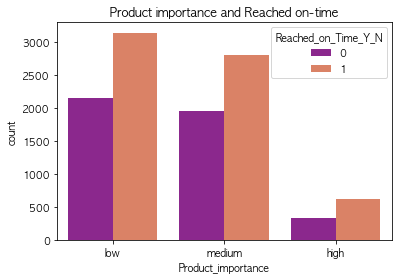

In [31]:
import seaborn as sb
from matplotlib import pyplot as plt
sb.countplot(x = "Product_importance", data = train, palette = "plasma",hue="Reached_on_Time_Y_N");
plt.title('Product importance and Reached on-time')
plt.show()

> 성별에 따른 Target Feature

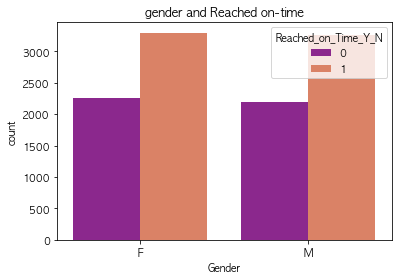

In [32]:
import seaborn as sb
from matplotlib import pyplot as plt
sb.countplot(x = "Gender", data = train, palette = "plasma",hue="Reached_on_Time_Y_N");
plt.title('gender and Reached on-time')
plt.show()

> 창고 구역별 Target Feature

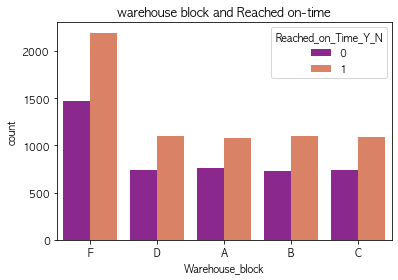

In [33]:
import seaborn as sb
from matplotlib import pyplot as plt
sb.countplot(x = "Warehouse_block", data = train, palette = "plasma",hue="Reached_on_Time_Y_N",order = train['Warehouse_block'].value_counts().index);
plt.title('warehouse block and Reached on-time')
plt.show()

> 운송 수단별 Target Feature

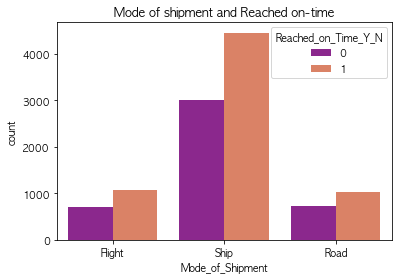

In [34]:
import seaborn as sb
from matplotlib import pyplot as plt
sb.countplot(x = "Mode_of_Shipment", data = train, palette = "plasma",hue="Reached_on_Time_Y_N");
plt.title('Mode of shipment and Reached on-time')
plt.show()

> 고객 응답 횟수별 Target Feature

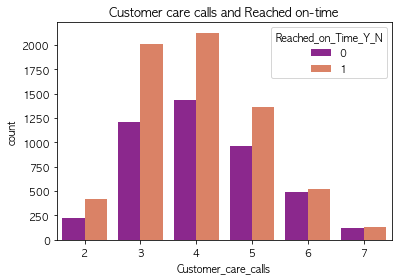

In [35]:
sb.countplot(x = "Customer_care_calls", data = train, palette = "plasma",hue="Reached_on_Time_Y_N");
plt.title('Customer care calls and Reached on-time')
plt.show()

### 4. 데이터 타입별 Feature 변환

#### 1) Feature 탐색

##### 총 Feature 개수 확인

In [36]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached_on_Time_Y_N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB
None


##### Feature 데이터 타입별 개수 확인

In [37]:
# 데이터 타입별 컬럼 수 확인
dtype_data = train.dtypes.reset_index()
dtype_data.columns = ["Count", "Column Type"]
dtype_data = dtype_data.groupby("Column Type").aggregate('count').reset_index()

print(dtype_data)

  Column Type  Count
0       int64      8
1      object      4


#### 2) 범주형 Feature
  * 데이터 확인
  * Feature 별 개수 시각화
  * 날짜/숫자/기간 등으로 변환해야 할 항목이 있는지 확인
  * Feature 별 개수 시각화
  * Feature 의 개수가 인코딩에 적합한가?

##### 데이터 확인

In [38]:
# pandas 의 select_dtypes 사용
train.select_dtypes(include=['object','category']).head()

,Warehouse_block,Mode_of_Shipment,Product_importance,Gender
0,D,Flight,low,F
1,F,Flight,low,M
2,A,Flight,low,M
3,B,Flight,medium,M
4,C,Flight,medium,F


##### Feature 제거

> Feature 별 유일한 값 개수 확인

In [39]:
# 유일한값 1개이면 불필요하여 제거 가능함
cat_feat = train.select_dtypes('object','category').columns.values
train_cat = train[cat_feat].copy()
print(train_cat.nunique().sort_values())

Gender                2
Mode_of_Shipment      3
Product_importance    3
Warehouse_block       5
dtype: int64


> 유일한 값이 1개인 경우 또는 모든 행의 값이 다른 경우는 제거한다
* Target Feature 가 포함되어 있으면 함께 제거

##### Feature 별 개수 시각화

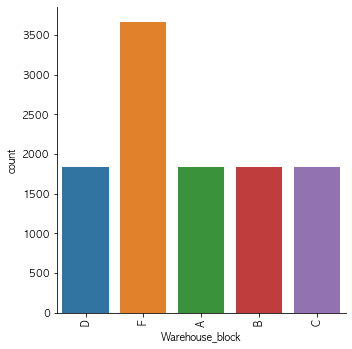

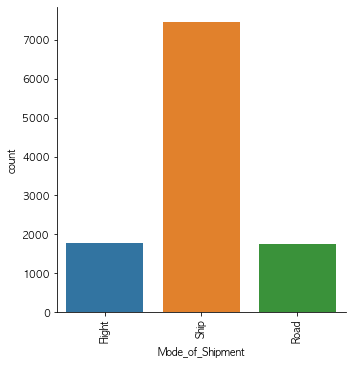

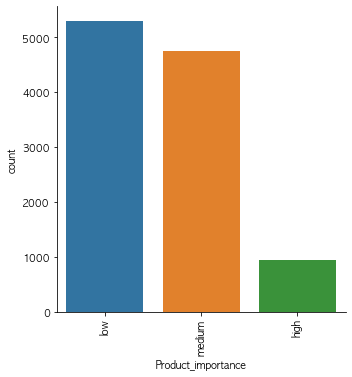

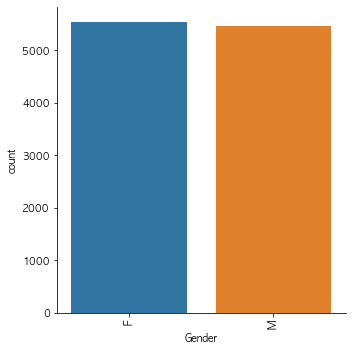

In [40]:
for col in train_cat.columns:
  fig = sns.catplot(x=col, kind="count", data=train_cat, hue=None)
  fig.set_xticklabels(rotation=90)
  plt.show()

##### Feature 의 개수가 인코딩에 적합한가?
  * 인코딩을 했을 경우 메모리 문제가 발생하지는 않는가?

> Feature 인코딩
* LabelEncoder : LabelEncoder 는 선형성을 가지는 머신러닝 기법에 쓰면 좋지 않다
* OneHotEncoder vs. get_dummies

In [41]:
###### 코드 작성 부분 시작 ######
# pandas 의 get_dummies 활용
train_cat_dummies = pd.get_dummies(train_cat)
###### 코드 작성 부분 마침 ######
train_cat_dummies.head(3)

,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,...,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M
0,False,False,False,True,False,True,...,False,False,True,False,True,False
1,False,False,False,False,True,True,...,False,False,True,False,False,True
2,True,False,False,False,False,True,...,False,False,True,False,False,True


#### 3) 숫자형 Feature
  * 데이터 확인
  * Feature 제거
  * Feature Skewness 확인

##### 데이터 확인

In [42]:
# pandas 의 select_dtypes 사용
train.select_dtypes(include=['number']).head()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached_on_Time_Y_N
0,1,4,2,177,3,44,1233,1
1,2,4,5,216,2,59,3088,1
2,3,2,2,183,4,48,3374,1
3,4,3,3,176,4,10,1177,1
4,5,2,2,184,3,46,2484,1


In [43]:
train.select_dtypes(include=np.number).head()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached_on_Time_Y_N
0,1,4,2,177,3,44,1233,1
1,2,4,5,216,2,59,3088,1
2,3,2,2,183,4,48,3374,1
3,4,3,3,176,4,10,1177,1
4,5,2,2,184,3,46,2484,1


In [44]:
num_feat = train.select_dtypes('number').columns.values
train_num = train[num_feat].copy()

##### Feature 제거

> Feature 별 유일한 값 개수 확인

In [45]:
###### 코드 작성 부분 시작 ######
print(train_num.nunique().sort_values())
###### 코드 작성 부분 마침 ######

Reached_on_Time_Y_N        2
Customer_rating            5
Customer_care_calls        6
Prior_purchases            8
Discount_offered          65
Cost_of_the_Product      215
Weight_in_gms           4034
ID                     10999
dtype: int64


In [46]:
print(train.shape)

(10999, 12)


> 유일한 값이 1개인 경우 또는 모든 행의 값이 다른 경우는 제거한다
* Target Feature 가 포함되어 있으면 함께 제거

In [47]:
train_num = train_num.drop(['ID','Reached_on_Time_Y_N'], axis=1, errors='ignore')

##### Feature Skewness 확인

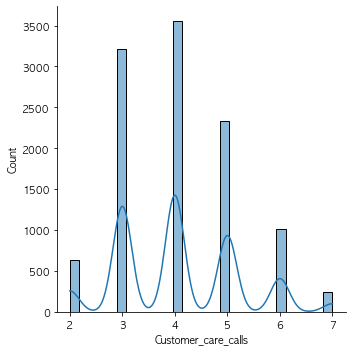

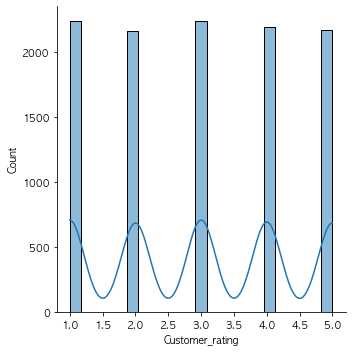

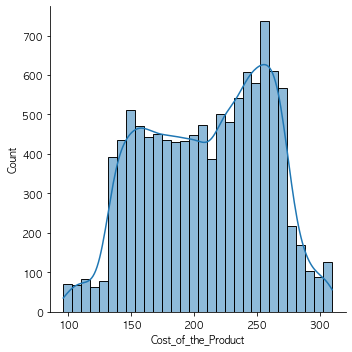

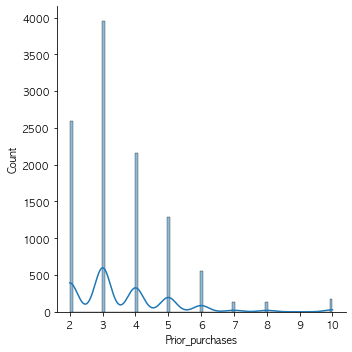

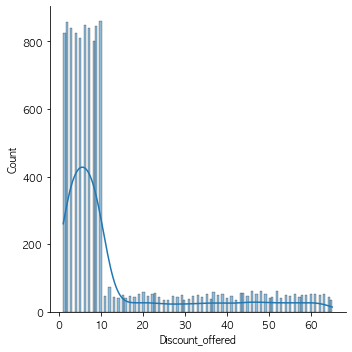

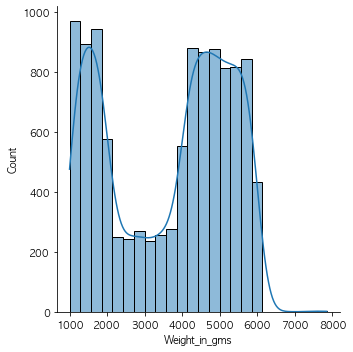

In [48]:
col_attrition_num = train_num.columns.values
for i in range(0,len(col_attrition_num)):
    sns.displot(train_num[col_attrition_num[i]],kde=True) # kde : kernel density

### 5. 상관성에 따른 Feature 정제

#### 1) 숫자형 Feature
  * 데이터 확인
  * 숫자형 컬럼들 간 Pearson R 상관 계수를 구한다
  * 상관 계수가 0.9 이상인 컬럼들 중 가장 큰 컬럼을 제거해 본다
  * 컬럼들 간 조합 생성 : comb_num_feat = np.array(list(combinations(num_feat, 2)))
  * Pearson R 상관 계수 구하기 : pearsonr(x1, x2)[0]

##### 데이터 확인

In [49]:
train_num.nunique().sort_values()

Customer_rating           5
Customer_care_calls       6
Prior_purchases           8
Discount_offered         65
Cost_of_the_Product     215
Weight_in_gms          4034
dtype: int64

##### 상관계수 구하기

* 방법 1

In [50]:
num_feat = train_num.columns.values
comb_num_feat = np.array(list(combinations(num_feat, 2)))
corr_num_feat = np.array([])
for comb in comb_num_feat:
    corr = pearsonr(train_num[comb[0]], train_num[comb[1]])[0]
    corr_num_feat = np.append(corr_num_feat, corr)

In [51]:
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.9]
high_corr_num

array([], shape=(0, 2), dtype='<U19')

* 방법 2

In [52]:
# plotly 안 보이는 문제 해결
import plotly.io as pio
pio.renderers.default = 'colab'
pio.renderers

data = [
    go.Heatmap(
        z=train_num.astype(float).corr().values, # 피어슨 상관계수
        x=train_num.columns.values,
        y=train_num.columns.values,
        colorscale='Viridis',
        reversescale = False,
        opacity = 1.0
        
    )
]


layout = go.Layout(
    title='숫자형 Feature 들의 피어슨 상관계수',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700,
    
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')



<Axes: >

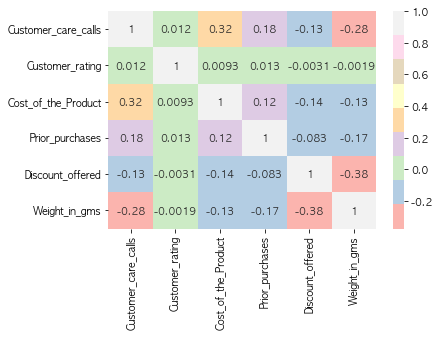

In [53]:
sns.heatmap(train_num.corr(),annot=True,cmap='Pastel1')

#### 2) 범주형 Feature
  * 데이터 확인

##### 데이터 확인

In [54]:
train_cat_dummies.nunique().sort_values()

Warehouse_block_A            2
Warehouse_block_B            2
Warehouse_block_C            2
Warehouse_block_D            2
Warehouse_block_F            2
Mode_of_Shipment_Flight      2
Mode_of_Shipment_Road        2
Mode_of_Shipment_Ship        2
Product_importance_high      2
Product_importance_low       2
Product_importance_medium    2
Gender_F                     2
Gender_M                     2
dtype: int64

In [55]:
train_cat_dummies.head()

,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,...,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M
0,False,False,False,True,False,True,...,False,False,True,False,True,False
1,False,False,False,False,True,True,...,False,False,True,False,False,True
2,True,False,False,False,False,True,...,False,False,True,False,False,True
3,False,True,False,False,False,True,...,False,False,False,True,False,True
4,False,False,True,False,False,True,...,False,False,False,True,True,False


In [56]:
from scipy.stats import chi2_contingency
import numpy as np

def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

In [57]:
rows= []

for var1 in train_cat_dummies:
  col = []
  for var2 in train_cat_dummies :
    cramers =cramers_V(train_cat_dummies[var1], train_cat_dummies[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = train_cat_dummies.columns, index =train_cat_dummies.columns)

df

,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,...,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M
Warehouse_block_A,1.00,0.04,0.04,0.04,0.1,0.00,...,0.00,0.00,0.00,0.00,0.0,0.0
Warehouse_block_B,0.04,1.00,0.04,0.04,0.1,0.00,...,0.00,0.00,0.00,0.00,0.0,0.0
Warehouse_block_C,0.04,0.04,1.00,0.04,0.1,0.00,...,0.00,0.00,0.00,0.00,0.0,0.0
Warehouse_block_D,0.04,0.04,0.04,1.00,0.1,0.00,...,0.00,0.00,0.00,0.00,0.0,0.0
Warehouse_block_F,0.10,0.10,0.10,0.10,1.0,0.00,...,0.00,0.00,0.00,0.00,0.0,0.0
Mode_of_Shipment_Flight,0.00,0.00,0.00,0.00,0.0,1.00,...,0.41,0.00,0.00,0.00,0.0,0.0
Mode_of_Shipment_Road,0.00,0.00,0.00,0.00,0.0,0.04,...,0.40,0.00,0.00,0.00,0.0,0.0
Mode_of_Shipment_Ship,0.00,0.00,0.00,0.00,0.0,0.41,...,1.00,0.00,0.00,0.00,0.0,0.0
Product_importance_high,0.00,0.00,0.00,0.00,0.0,0.00,...,0.00,1.00,0.09,0.07,0.0,0.0
Product_importance_low,0.00,0.00,0.00,0.00,0.0,0.00,...,0.00,0.09,1.00,0.71,0.0,0.0


In [58]:
np.sum(df > 0.9)

Warehouse_block_A            1
Warehouse_block_B            1
Warehouse_block_C            1
Warehouse_block_D            1
Warehouse_block_F            1
Mode_of_Shipment_Flight      1
Mode_of_Shipment_Road        1
Mode_of_Shipment_Ship        1
Product_importance_high      1
Product_importance_low       1
Product_importance_medium    1
Gender_F                     2
Gender_M                     2
dtype: int64

In [59]:
# Concat the two dataframes together columnwise
train_final = pd.concat([train["Reached_on_Time_Y_N"], train_num, train_cat_dummies], axis=1)

In [60]:
train_final.head()

,Reached_on_Time_Y_N,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,...,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M
0,1,4,2,177,3,44,...,False,False,True,False,True,False
1,1,4,5,216,2,59,...,False,False,True,False,False,True
2,1,2,2,183,4,48,...,False,False,True,False,False,True
3,1,3,3,176,4,10,...,False,False,False,True,False,True
4,1,2,2,184,3,46,...,False,False,False,True,True,False


In [61]:
target = train["Reached_on_Time_Y_N"]

In [62]:
X=pd.concat([train_num, train_cat_dummies], axis=1)
Y=train["Reached_on_Time_Y_N"]

In [63]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,
                                               test_size=0.30)

## 03. 예측 분석

#### 고객 정보를 활용한 정시 배송 예측

#### 1) Logistic Regression

##### 모델 생성

In [64]:
###### 코드 작성 부분 시작 ######
model = LogisticRegression()
model.fit(X_train, y_train)
lr_predictions = model.predict(X_test)
###### 코드 작성 부분 마침 ######

##### 모델 **평가**

In [65]:
print("Accuracy score: {}".format(accuracy_score(y_test, lr_predictions)))
print("="*60)
print(classification_report(y_test, lr_predictions))
# classification_report > 정밀도, 정확도, 재현율, ROC를 만들수 있는 수치 제공


Accuracy score: 0.6333333333333333
              precision    recall  f1-score   support

           0       0.55      0.57      0.56      1338
           1       0.70      0.68      0.69      1962

    accuracy                           0.63      3300
   macro avg       0.62      0.62      0.62      3300
weighted avg       0.64      0.63      0.63      3300



##### RFE(Recursive Feature Elimination) 적용

In [66]:
# Backward
# 여러번 반복해서 적당한 feature를 찾음
from sklearn.feature_selection import RFE
###### 코드 작성 부분 시작 ######
# rfe에 모델넣고, 몇개 선택할건지?(default값은 0임)
rfe = RFE(estimator=model, n_features_to_select=6)
X_rfe = rfe.fit_transform(X, Y)
model.fit(X_rfe, Y)
###### 코드 작성 부분 마침 ######
print(rfe.support_)
print(rfe.ranking_)
print(X.columns[rfe.support_])

[False False False  True  True False  True False False False False False
 False False False  True  True False  True]
[12  9 13  1  1 14  1  2  8  4  7 10  6 11  3  1  1  5  1]
Index(['Prior_purchases', 'Discount_offered', 'Warehouse_block_A',
       'Product_importance_low', 'Product_importance_medium', 'Gender_M'],
      dtype='object')


##### SelectKBest 적용

In [67]:
# Univariate Selection 중에 하나, 독립변수 여러개인 방법
###### 코드 작성 부분 시작 ######
# SelectKBest 사용 (chi2, k=6) 후 fit_transform
# 카이제곱 통계량을 기준으로 가장 best를 뽑는지?
X_new = SelectKBest(chi2, k=6).fit_transform(X, Y)
###### 코드 작성 부분 마침 ######

In [68]:
X_new_train,X_new_test,y_new_train,y_new_test=train_test_split(X_new,Y,
                                               test_size=0.30)

In [69]:
model=LogisticRegression()
model.fit(X_new_train,y_new_train)
lr_predictions=model.predict(X_new_test)

In [70]:
print("Accuracy score: {}".format(accuracy_score(y_new_test, lr_predictions)))
print("="*60)
print(classification_report(y_new_test, lr_predictions))

Accuracy score: 0.6272727272727273
              precision    recall  f1-score   support

           0       0.53      0.58      0.55      1307
           1       0.70      0.66      0.68      1993

    accuracy                           0.63      3300
   macro avg       0.62      0.62      0.62      3300
weighted avg       0.63      0.63      0.63      3300



#### 2) SVM

##### Feature Scailing

In [71]:
###### 코드 작성 부분 시작 ######
# Standard Scaling

sc_x = StandardScaler()
X_train_sc = sc_x.fit_transform(X_train)
X_test_sc = sc_x.transform(X_test)

###### 코드 작성 부분 마침 ######

##### 모델 생성

In [72]:
###### 코드 작성 부분 시작 ######
# svm, kernel='linear'

clf = svm.SVC(kernel='linear')
clf.fit(X_train_sc, y_train)
clf_predictions=clf.predict(X_test_sc)
# fitting..
# clf_predictions = 
###### 코드 작성 부분 마침 ######

##### 모델 평가

In [73]:
print("Accuracy score: {}".format(accuracy_score(y_test, clf_predictions.round(), normalize=True)))
print("="*60)
print(classification_report(y_test, clf_predictions))

Accuracy score: 0.6545454545454545
              precision    recall  f1-score   support

           0       0.56      0.71      0.63      1338
           1       0.76      0.62      0.68      1962

    accuracy                           0.65      3300
   macro avg       0.66      0.66      0.65      3300
weighted avg       0.68      0.65      0.66      3300



##### SelectKBest 적용 후 평가

In [74]:
X_norm = MinMaxScaler().fit_transform(X)
X_new = SelectKBest(chi2, k=6).fit_transform(X_norm, Y)


X_new_train,X_new_test,y_new_train,y_new_test=train_test_split(X_new,Y,
                                               test_size=0.30)

clf = svm.SVC(kernel='linear')
clf.fit(X_new_train,y_new_train)
clf_predictions=clf.predict(X_new_test)

print("Accuracy score: {}".format(accuracy_score(y_new_test, clf_predictions.round(), normalize=True)))
print("="*60)
print(classification_report(y_new_test, clf_predictions))

Accuracy score: 0.6596969696969697
              precision    recall  f1-score   support

           0       0.56      0.74      0.64      1345
           1       0.77      0.60      0.68      1955

    accuracy                           0.66      3300
   macro avg       0.67      0.67      0.66      3300
weighted avg       0.69      0.66      0.66      3300



#### 3) RandomForest

##### 모델 생성

In [75]:
###### 코드 작성 부분 시작 ######
# n_estimators = 20, random_state = 0

rf = RandomForestRegressor(n_estimators=2, random_state=0)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
###### 코드 작성 부분 마침 ######

In [76]:
print("Accuracy score: {}".format(accuracy_score(y_test, y_pred.round())))

Accuracy score: 0.6496969696969697


##### Feature Importances

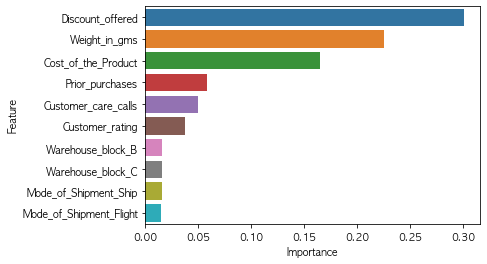

In [77]:
feat = X.columns.values
imp = rf.feature_importances_
df = pd.DataFrame({'Feature': feat, 'Importance': imp})
df = df.sort_values('Importance', ascending=False)[:10]
sns.barplot(x='Importance', y='Feature', data=df);

In [78]:

trace = go.Scatter(
    y = rf.feature_importances_,
    x = X.columns.values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        color = rf.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = X.columns.values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

##### RFE(Recursive Feature Elimination) 적용

In [79]:
# RFE(Recursive Feature Elimination) 적용
rfe = RFE(estimator=rf, n_features_to_select=6)
# Transforming data using RFE
X_rfe = rfe.fit_transform(X, Y)
# Fitting the data to model
rf.fit(X_rfe, Y)
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True False False False False False False
 False False False False False False False]
[ 1  1  1  1  1  1  9  7  8  6  4 11 14  5 13  3 10 12  2]


##### SelectKBest 적용 후 평가

In [80]:
X_new = SelectKBest(chi2, k=6).fit_transform(X, Y)

X_new_train,X_new_test,y_new_train,y_new_test=train_test_split(X_new,Y,
                                               test_size=0.30)

rf = RandomForestRegressor(n_estimators=20, random_state=0)
rf.fit(X_new_train, y_new_train)
y_pred = rf.predict(X_new_test)

print("Accuracy score: {}".format(accuracy_score(y_new_test, y_pred.round())))

Accuracy score: 0.6542424242424243


#### 4) XGBoost

##### 모델 생성

In [81]:
###### 코드 작성 부분 시작 ######
xgmodel = XGBClassifier()
xgmodel.fit(X_train, y_train)
y_pred = xgmodel.predict(X_test)
###### 코드 작성 부분 마침 ######

In [82]:
print("Accuracy score: {}".format(accuracy_score(y_test, y_pred.round())))

Accuracy score: 0.6542424242424243


##### RFE(Recursive Feature Elimination) 적용

In [83]:
rfe = RFE(estimator=xgmodel, n_features_to_select=6)
X_rfe = rfe.fit_transform(X, Y)
xgmodel.fit(X_rfe, Y)
print(rfe.support_)
print(rfe.ranking_)

[False False False  True  True  True  True False False  True False False
  True False False False False False False]
[ 3  4  2  1  1  1  1  6  5  1 13  8  1 12 11  7  9 10 14]


##### SelectKBest 적용 후 평가

In [84]:
X_new = SelectKBest(chi2, k=6).fit_transform(X, Y)

X_new_train,X_new_test,y_new_train,y_new_test=train_test_split(X_new,Y,
                                               test_size=0.30)

xgmodel=XGBClassifier()
xgmodel.fit(X_new_train,y_new_train)
y_pred = xgmodel.predict(X_new_test)

print("Accuracy score: {}".format(accuracy_score(y_new_test, y_pred.round())))

Accuracy score: 0.6609090909090909


## 04. 군집 분석

#### 군집 분석을 활용한 고객 Segmentation

#### 1) K-Means Clustering

##### Elbow 방법 적용

In [85]:
# 정시에 배송되지 않는것만 clustering데이터로 활용
# 정시에 되지 않는 것들만 segmentation을 해보면 인사이트를 얻을 수 있음!
clustdata=train_final[(train_final.Reached_on_Time_Y_N == 1)]

In [86]:
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(clustdata)
    wcss.append(kmeans.inertia_)

WCSS는 클러스터의 각 구성원과 중심 사이의 거리 제곱의 합

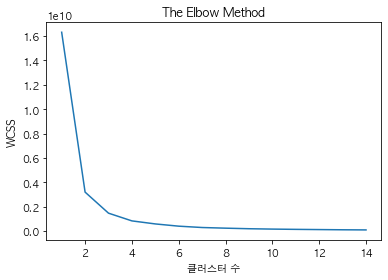

In [87]:
plt.plot(range(1,15), wcss)
plt.title('The Elbow Method')
plt.xlabel('클러스터 수')
plt.ylabel('WCSS')
plt.show()

In [88]:
km = KMeans(n_clusters=2, init='k-means++', n_init=10)
c = km.fit_predict(clustdata) 
c

array([1, 1, 0, ..., 1, 1, 1], dtype=int32)

In [89]:
clustdata["Cluster"]= c
clustdata.head()

,Reached_on_Time_Y_N,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,...,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M,Cluster
0,1,4,2,177,3,44,...,False,True,False,True,False,1
1,1,4,5,216,2,59,...,False,True,False,False,True,1
2,1,2,2,183,4,48,...,False,True,False,False,True,0
3,1,3,3,176,4,10,...,False,False,True,False,True,1
4,1,2,2,184,3,46,...,False,False,True,True,False,1


In [90]:
clustdata.groupby(['Cluster']).mean()

,Reached_on_Time_Y_N,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,...,Mode_of_Shipment_Ship,Product_importance_high,Product_importance_low,Product_importance_medium,Gender_F,Gender_M
Cluster,,,,,,,,,,,,,
0,1.0,3.821617,3.020749,208.292970,3.354289,11.154227,...,0.673583,0.109631,0.443791,0.446578,0.492722,0.507278
1,1.0,4.155969,2.991302,206.317037,3.637373,25.936713,...,0.685063,0.078584,0.511998,0.409418,0.511398,0.488602


##### 군집화된 데이터 Scailing

In [91]:
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(clustdata) 

X_normalized = normalize(X_scaled) 
X_normalized = pd.DataFrame(X_normalized)

##### PCA 적용 (n=2)

In [92]:
# clustering을 나누는 주된 성분인지?

###### 코드 작성 부분 시작 ######
#  n_components = 2

pca = PCA(n_components = 2) 
# fit_transform..
###### 코드 작성 부분 마침 ######
X_principal = pca.fit_transform(X_normalized )
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2']

In [93]:
c1 = km.fit_predict(X_principal) 
c1

array([1, 0, 0, ..., 1, 0, 1], dtype=int32)

In [94]:
result=pd.DataFrame({'P1' : X_principal.iloc[:,0] ,'P2' : X_principal.iloc[:,1]})
result['Cluster']=pd.Series(c1, index=result.index)
result.head()

,P1,P2,Cluster
0,-0.511708,-0.226470,1
1,-0.314950,0.372669,0
2,-0.002725,0.293311,0
3,-0.107398,0.221810,0
4,-0.194864,-0.367855,1


##### 주성분-클러스터 그래프

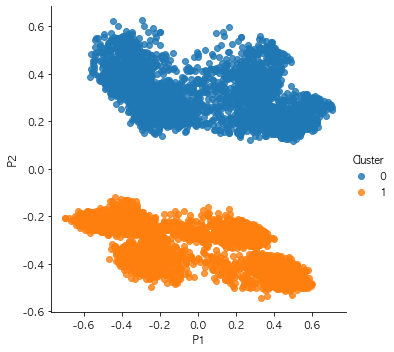

In [95]:
import seaborn as sns
facet = sns.lmplot(data=result,x='P1',y='P2',hue='Cluster', 
                   fit_reg=False, legend=True, legend_out=True)

In [96]:
result['Cluster'].value_counts()

Cluster
1    3296
0    3267
Name: count, dtype: int64

##### PCA 후 Elbow 방법 적용

In [97]:
wcss=[]

for i in range(2,15):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
    kmeans.fit(X_principal)
    wcss.append(kmeans.inertia_)

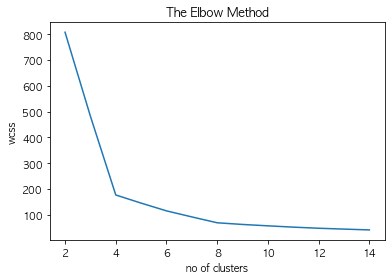

In [98]:
plt.plot(range(2,15), wcss)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('wcss')
plt.show()

In [99]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=4, init='k-means++', n_init=10)
c = km.fit_predict(X_principal) 
c

array([2, 0, 0, ..., 2, 0, 2], dtype=int32)

In [100]:
result=pd.DataFrame({'P1' : X_principal.iloc[:,0] ,'P2' : X_principal.iloc[:,1]})
result['Cluster']=pd.Series(c, index=result.index)
result.head()

,P1,P2,Cluster
0,-0.511708,-0.226470,2
1,-0.314950,0.372669,0
2,-0.002725,0.293311,0
3,-0.107398,0.221810,0
4,-0.194864,-0.367855,2


##### 새로운 주성분-클러스터 그래프

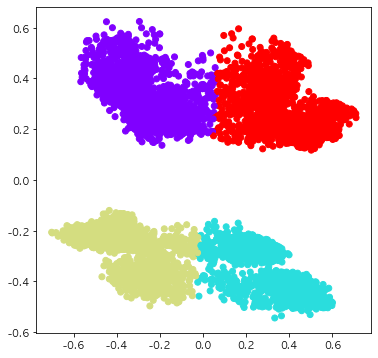

In [101]:
# Visualizing the clustering 
plt.figure(figsize =(6, 6)) 
plt.scatter(result.iloc[:,0],result.iloc[:,1],c=result['Cluster'], cmap ='rainbow') 
plt.show()

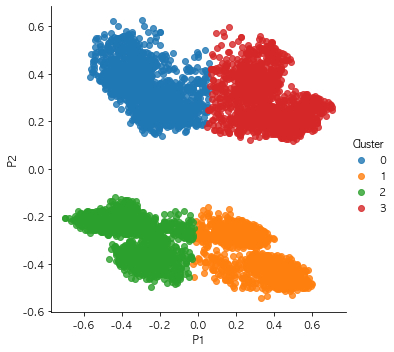

In [102]:
import seaborn as sns
facet = sns.lmplot(data=result,x='P1',y='P2',hue='Cluster', 
                   fit_reg=False, legend=True, legend_out=True)